# GT4Py Tutorial

### Introduction

This notebook will show how to create a simple GT4Py stencil that copies data from one varaible to another.  This is demonstrated through an object-oriented approach so that the develop gains familiarity on such an approach.

### Notebook Requirements

- Python v3.11.7 or greater
- [NOAA/NASA Domain Specific Language Middleware](https://github.com/NOAA-GFDL/NDSL)
- `ipykernel==6.1.0`
- [`ipython_genutils`](https://pypi.org/project/ipython_genutils/)

### Creating the `StencilFactory` object

The `boilerplate` module contains a function `get_one_tile_factory` that will establish a `StencilFactory` object.  The `StencilFactory` object contains information about the domain size, halo size, and the backend that executes the stencil.

In [1]:
from boilerplate import get_one_tile_factory, plot_field_at_k0
from ndsl import StencilFactory

nx = 6
ny = 6
nz = 1
nhalo = 1
backend="numpy"

stencil_factory: StencilFactory = get_one_tile_factory(nx, ny, nz, nhalo, backend)


2024-04-22 13:27:14|INFO|rank 0|ndsl.logging:Constant selected: ConstantVersions.GFS


### Creating the Copy stencil

The `NDSL` and `gt4py` module contain key terms that will be used to create the stencil.  

- `FloatField` : Generally can be thought of as a `gt4py` 3-dimensional array (or storage) of floating point values.
- `PARALLEL`   : This keyword means that there is no assumed order to perform calcuations in the `k` (3rd) dimension of a `gt4py` storage.

Since stencil calculations generally are based localized computations, `gt4py` stencils are written using variables and their relative location to the value of interest.  

In [22]:
from ndsl.dsl.typing import FloatField
from gt4py.cartesian.gtscript import PARALLEL, computation, interval

def copy_field_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in

In [23]:
class CopyField:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field = stencil_factory.from_origin_domain(
            copy_field_stencil, # <-- gt4py stencil function wrapped into NDSL
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__( # <-- Runtime path
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field(field_in, field_out)
        
        
copy_field = CopyField(stencil_factory)

Min and max values: 1.0 0.0


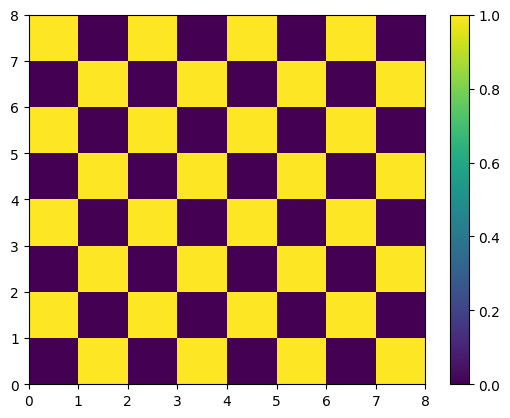

Min and max values: 0.0 0.0


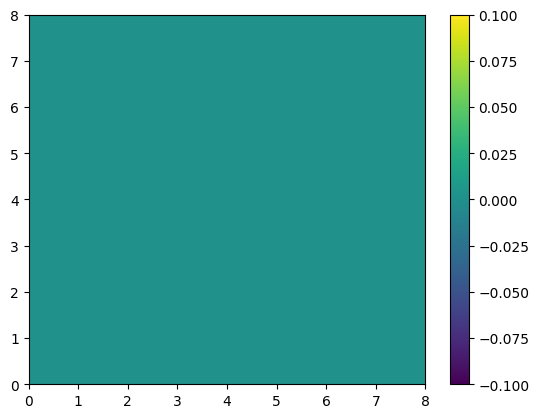

In [24]:
## Change this to Quantity

import gt4py.storage as gt_storage
import numpy as np

size = (nx + 2 * nhalo) * (ny + 2 * nhalo) * nz
shape = (nx + 2 * nhalo, ny + 2 * nhalo, nz)


qty_zero = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=shape,
)

qty_out = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=shape,
)

arr = np.zeros(shape)
qty_in = gt_storage.from_array(
    data=np.indices(shape).sum(axis=0) % 2,
    backend=backend,
    dtype=float,
)

plot_field_at_k0(qty_in)
plot_field_at_k0(qty_out)


Min and max values: 1.0 0.0


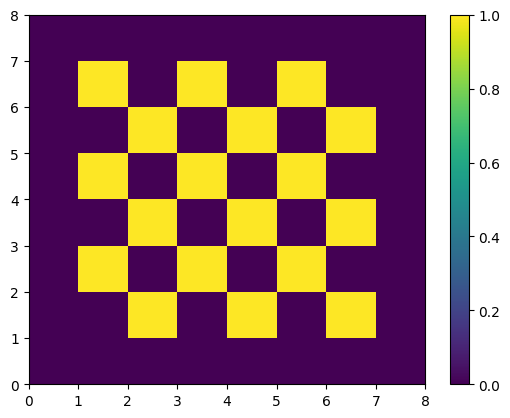

In [25]:
copy_field(qty_in, qty_out)
plot_field_at_k0(qty_out)


Min and max values: 0.0 0.0


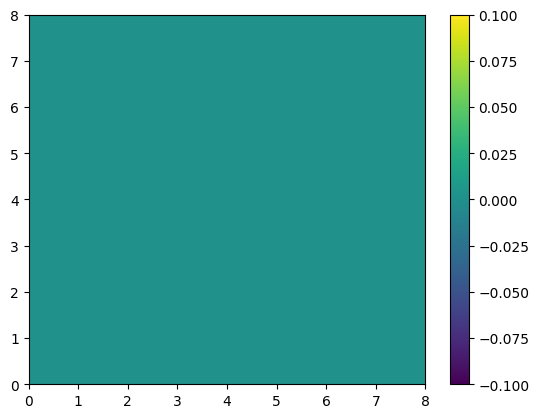

In [26]:
from gt4py.cartesian.gtscript import J

def copy_field_offset_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in[J-1]
        
class CopyFieldOffset:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field_offset = stencil_factory.from_origin_domain(
            copy_field_offset_stencil,
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__(
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field_offset(field_in, field_out)
        
copy_field_offset = CopyFieldOffset(stencil_factory)
        
copy_field(qty_zero, qty_out)
plot_field_at_k0(qty_out)

Min and max values: 0.0 0.0


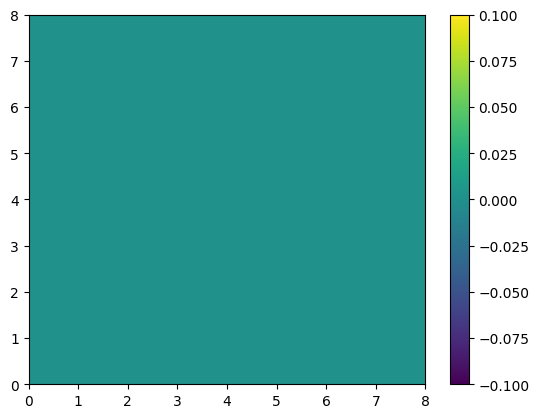

Min and max values: 1.0 0.0


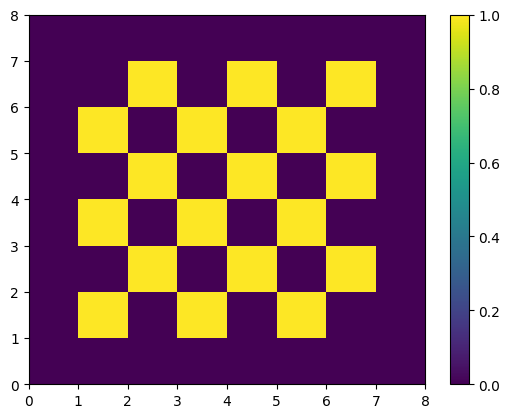

In [27]:
plot_field_at_k0(qty_out)
copy_field_offset(qty_in, qty_out)
plot_field_at_k0(qty_out)